In [15]:
!pip install numpy pandas scipy anndata

In [4]:
%pip install anndata

  Using cached anndata-0.10.7-py3-none-any.whl (122 kB)
  Using cached array_api_compat-1.6-py3-none-any.whl (36 kB)
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import anndata as ad

class IDEADataSet:
    def __init__(self, counts, sample_info):
        self.counts = counts
        self.sample_info = sample_info
        self.normalizedCounts = None
        self.sizeFactors = None
        self.meanVarZero = None
        self.designMatrix = None

    def get_counts(self):
        return self.counts

    def get_sample_info(self):
        return self.sample_info
    
    def to_anndata(self):
        # Create an AnnData object
        adata = ad.AnnData(X=self.counts.values, obs=self.sample_info, var=pd.DataFrame(index=self.counts.columns))
        return adata

In [2]:
# Importing the classes and functions defined above
# In a real package, you would use: from IDEA.dataset import IDEADataSet

# Create sample data
counts = pd.DataFrame({
    'gene1': [10, 15, 20],
    'gene2': [5, 8, 12],
    'gene3': [30, 45, 50]
}, index=['sample1', 'sample2', 'sample3'])

sample_info = pd.DataFrame({
    'condition': ['A', 'B', 'A']
}, index=['sample1', 'sample2', 'sample3'])

# Initialize IDEADataSet
dds = IDEADataSet(counts, sample_info)

# Test the methods
print("Counts:\n", dds.get_counts())
print("Sample Info:\n", dds.get_sample_info())

# Convert to AnnData
adata = dds.to_anndata()
print("AnnData object:\n", adata)


Counts:
          gene1  gene2  gene3
sample1     10      5     30
sample2     15      8     45
sample3     20     12     50
Sample Info:
         condition
sample1         A
sample2         B
sample3         A
AnnData object:
 AnnData object with n_obs × n_vars = 3 × 3
    obs: 'condition'


In [3]:
def median_of_ratios(adata):
    # Calculate the geometric mean of each gene across all samples
    geometric_means = np.exp(np.log(adata.X + 1).mean(axis=0))
    
    # Compute ratios for each gene in each sample to the geometric mean
    ratios = adata.X / geometric_means
    
    # Median of ratios for each sample
    size_factors = np.median(ratios, axis=1)
    
    return size_factors

def size_factors(adata):
    adata.obs['size_factors'] = median_of_ratios(adata)
    return adata.obs['size_factors']

def normalize_counts(adata):
    if 'size_factors' not in adata.obs:
        size_factors(adata)
    
    # Normalize counts
    adata.layers['normalized'] = adata.X / adata.obs['size_factors'].values[:, np.newaxis]
    return adata

# Sample data
counts = pd.DataFrame({
    'gene1': [10, 15, 20],
    'gene2': [5, 8, 12],
    'gene3': [30, 45, 50]
}, index=['sample1', 'sample2', 'sample3'])

sample_info = pd.DataFrame({
    'condition': ['A', 'B', 'A']
}, index=['sample1', 'sample2', 'sample3'])

# Convert to AnnData
adata = ad.AnnData(X=counts.values, obs=sample_info, var=pd.DataFrame(index=counts.columns))

# Normalize counts
size_factors(adata)
normalize_counts(adata)

# Print results
print("Size Factors:\n", adata.obs['size_factors'])
print("Normalized Counts:\n", adata.layers['normalized'])


Size Factors:
 sample1    0.646779
sample2    0.970169
sample3    1.293558
Name: size_factors, dtype: float64
Normalized Counts:
 [[15.46122811  7.73061405 46.38368432]
 [15.46122811  8.24598832 46.38368432]
 [15.46122811  9.27673686 38.65307026]]


In [4]:
# Normalize counts
size_factors(adata)
normalize_counts(adata)

# Print results
print("Size Factors:\n", adata.obs['size_factors'])
print("Normalized Counts:\n", adata.layers['normalized'])

Size Factors:
 sample1    0.646779
sample2    0.970169
sample3    1.293558
Name: size_factors, dtype: float64
Normalized Counts:
 [[15.46122811  7.73061405 46.38368432]
 [15.46122811  8.24598832 46.38368432]
 [15.46122811  9.27673686 38.65307026]]


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def estimate_dispersions(dds):
    """
    Estimate the dispersions for each gene.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    pd.Series: Pandas Series of dispersions with gene identifiers.
    """
    counts = dds.X
    means = counts.mean(axis=0)
    variances = counts.var(axis=0)
    dispersions = variances / means
    dds.var['dispersion'] = dispersions
    return dds.var['dispersion']

def dispersion_trend(mean, a, b):
    """
    Model function for fitting the dispersion trend.
    
    Parameters:
    mean (float): Mean expression level.
    a (float): Coefficient a.
    b (float): Coefficient b.
    
    Returns:
    float: Fitted dispersion value.
    """
    return a / mean + b

def fit_dispersion_trend(dds):
    """
    Fit the dispersion trend across genes.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    np.ndarray: Array of fitted dispersions.
    """
    means = dds.X.mean(axis=0)
    dispersions = dds.var['dispersion'].values
    
    # Filter out zero means to avoid division by zero
    non_zero_means = means[means > 0]
    non_zero_dispersions = dispersions[means > 0]
    
    # Fit the model to the data
    popt, _ = curve_fit(dispersion_trend, non_zero_means, non_zero_dispersions)
    
    # Apply the fitted model to all means
    fitted_dispersions = dispersion_trend(means, *popt)
    dds.var['fitted_dispersion'] = fitted_dispersions
    
    return fitted_dispersions

def shrink_dispersions(dds):
    """
    Shrink the dispersions towards the fitted trend.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    pd.Series: Pandas Series of shrunken dispersions with gene identifiers.
    """
    raw_dispersions = dds.var['dispersion']
    fitted_dispersions = dds.var['fitted_dispersion']
    
    # Shrinkage formula: weighted average of raw and fitted dispersions
    shrunken_dispersions = 1 / (1 / raw_dispersions + 1 / fitted_dispersions)
    dds.var['shrunken_dispersion'] = shrunken_dispersions
    
    return dds.var['shrunken_dispersion']


In [6]:
# Estimate dispersions
estimate_dispersions(adata)

# Fit dispersion trend
fit_dispersion_trend(adata)

# Shrink dispersions
shrink_dispersions(adata)

# Print results
print("Raw Dispersions:\n", adata.var['dispersion'])
print("Fitted Dispersions:\n", adata.var['fitted_dispersion'])
print("Shrunken Dispersions:\n", adata.var['shrunken_dispersion'])

Raw Dispersions:
 gene1    1.111111
gene2    0.986667
gene3    1.733333
Name: dispersion, dtype: float64
Fitted Dispersions:
 gene1    1.303898
gene2    0.900984
gene3    1.626230
Name: fitted_dispersion, dtype: float64
Shrunken Dispersions:
 gene1    0.599905
gene2    0.470940
gene3    0.839037
Name: shrunken_dispersion, dtype: float64


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import rankdata

class IDEAResults:
    def __init__(self, dds, contrast):
        self.dds = dds
        self.contrast = contrast
        self.results = None
    
    def get_results(self):
        return self.results
    
def idea(dds, contrast):
    """
    Perform differential expression analysis.

    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.
    contrast (tuple): A tuple specifying the contrast for differential expression (e.g., ('condition', 'A', 'B')).

    Returns:
    IDEAResults: Object containing the results of the differential expression analysis.
    """
    # Extract counts and metadata
    counts = dds.layers['normalized']
    phenotype_data = dds.obs
    genes = dds.var.index
    condition = contrast[0]
    level1 = contrast[1]
    level2 = contrast[2]

    # Debugging output to ensure correct levels in phenotype data
    print("Phenotype data:")
    print(phenotype_data[condition])
    print(f"Expected levels: {level1}, {level2}")

    # Create design matrix
    design_matrix = pd.get_dummies(phenotype_data[condition], drop_first=True)
    print("Design matrix:")
    print(design_matrix.head())


    # Fit the model for each gene
    results = []
    for i, gene in enumerate(genes):
        y = counts[:, i]
        model = sm.OLS(y, design_matrix).fit()
        summary = model.summary2().tables[1]
        log2_fold_change = summary.loc[level2, 'Coef.']
        p_value = summary.loc[level2, 'P>|t|']
        results.append({
            'gene': gene,
            'log2_fold_change': log2_fold_change,
            'p_value': p_value
        })

    results_df = pd.DataFrame(results)
    results_df['padj'] = adjust_pvalues(results_df['p_value'])

    # Create IDEAResults object
    idea_results = IDEAResults(dds, contrast)
    idea_results.results = results_df

    return idea_results

def adjust_pvalues(pvalues):
    """
    Adjust p-values using the Benjamini-Hochberg method.

    Parameters:
    pvalues (pd.Series): Series of p-values.

    Returns:
    pd.Series: Series of adjusted p-values.
    """
    pvalues_sorted = np.sort(pvalues)
    pvalues_order = np.argsort(pvalues)
    n = len(pvalues)
    adjusted_pvalues = np.zeros(n)
    cumulative_min = np.inf
    for i in range(n-1, -1, -1):
        pval = pvalues_sorted[i]
        cumulative_min = min(cumulative_min, pval * n / (i + 1))
        adjusted_pvalues[pvalues_order[i]] = cumulative_min
    return adjusted_pvalues


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotVolcano(res, condition1, condition2, alpha=0.05, lfc_threshold=1):
    """
    Generate a volcano plot for the differential expression results.

    Parameters:
    - res: DataFrame containing the differential expression results.
    - condition1: The first condition in the contrast.
    - condition2: The second condition in the contrast.
    - alpha: Significance level for adjusted p-values.
    - lfc_threshold: Log fold change threshold for differential expression.
    """
    # Create a column for significant genes
    res['-log10(padj)'] = -np.log10(res['padj'])
    res['significant'] = (res['padj'] < alpha) & (abs(res['log2_fold_change']) > lfc_threshold)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=res, x='log2_fold_change', y='-log10(padj)', hue='significant',
                    palette={True: 'red', False: 'grey'}, edgecolor=None, alpha=0.7)
    plt.axhline(y=-np.log10(alpha), linestyle='--', color='black', linewidth=0.8)
    plt.axvline(x=lfc_threshold, linestyle='--', color='black', linewidth=0.8)
    plt.axvline(x=-lfc_threshold, linestyle='--', color='black', linewidth=0.8)
    plt.title(f'Volcano Plot: {condition1} vs {condition2}')
    plt.xlabel(f'Log2 Fold Change ({condition1} / {condition2})')
    plt.ylabel('-Log10 Adjusted P-Value')
    plt.show()

def plotHeatmap(res, adata, top_n=20):
    """
    Generate a heatmap of the top differentially expressed genes.

    Parameters:
    - res: DataFrame containing the differential expression results.
    - adata: AnnData object containing the normalized counts.
    - top_n: Number of top genes to display.
    """
    top_genes = res.sort_values('padj').head(top_n)['gene']
    data = adata[:, top_genes].X

    plt.figure(figsize=(10, 10))
    sns.heatmap(data, yticklabels=adata.obs.index, xticklabels=top_genes, cmap='viridis')
    plt.title('Heatmap of Top Differentially Expressed Genes')
    plt.xlabel('Genes')
    plt.ylabel('Samples')
    plt.show()


In [61]:
# Split the file paths into conditions and replicates
files = ['Chow_Rep1.genes.results', 'Chow_Rep2.genes.results', 'Chow_Rep3.genes.results', 
        'HFD_Rep1.genes.results', 'HFD_Rep2.genes.results', 'HFD_Rep3.genes.results']
conditions = []
replicates = []
for file_path in files:
    condition, replicate = file_path.split("/")[-1].split("_")
    conditions.append(condition)
    replicates.append(replicate[:-13])  # Remove ".genes.results" from the replicate

# Create a DataFrame with the conditions and replicates
samples = pd.DataFrame({"run": replicates, "condition": conditions}, index=replicates)

# Initialize an empty DataFrame
df_final = pd.DataFrame()

# Loop over each file
for i, file in enumerate(files):
    # Read the file into a DataFrame
    df = pd.read_csv(file, sep="\t", usecols=[0, 4], names=["gene_id", samples.iloc[i, 0]], header=None)

    # If this is the first file, copy it to df_final
    if df_final.empty:
        df_final = df
    else:
        # Otherwise, merge the new DataFrame with df_final
        df_final = pd.merge(df_final, df, on="gene_id", how="outer")

# Filter rows based on the sum of values, excluding the 'gene_id' column
numeric_cols = df_final.columns[1:]  # All columns except 'gene_id'
df_final[numeric_cols] = df_final[numeric_cols].apply(pd.to_numeric, errors='coerce')
min_sum = 10  # Replace with your desired minimum sum
filtered_df = df_final.loc[df_final[numeric_cols].sum(axis=1) >= min_sum, :]

# Write the filtered DataFrame to a new file
filtered_df.to_csv("filtered_merged_file.csv", index=False)

# Final part is actually implementing deseq, need to get out "gene_id", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj" from the dds

In [62]:
filtered_df.set_index('gene_id', inplace=True)
counts = filtered_df.transpose()
counts

gene_id,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000093,ENSMUSG00000000120,...,ENSMUSG00000099083,ENSMUSG00000099137,ENSMUSG00000099146,ENSMUSG00000099227,ENSMUSG00000099241,ENSMUSG00000099242,ENSMUSG00000099250,ENSMUSG00000099297,ENSMUSG00000099325,ENSMUSG00000099329
Rep1._x,1212.0,15.0,18423.0,515.0,71.0,104.0,90.0,1013.29,28.0,22.0,...,553.85,12.46,453.0,0.00,0.00,12.0,120.00,11.0,3.0,0.00
Rep2._x,1187.0,32.0,17917.0,593.0,60.0,193.0,113.0,993.65,17.0,60.0,...,494.00,9.50,347.0,68.40,0.00,6.0,293.00,21.0,1.5,9.91
Rep3._x,1154.0,10.0,15619.0,606.0,44.0,189.0,103.0,990.37,24.0,73.0,...,400.40,6.16,375.0,62.40,0.00,7.0,134.28,16.0,2.0,1.11
Rep1._y,1031.0,16.0,16395.0,801.0,45.0,139.0,88.0,804.94,22.0,57.0,...,332.88,8.12,326.0,111.80,21.64,8.0,44.00,13.0,5.5,0.00
Rep2._y,1274.0,11.0,16006.0,733.0,46.0,114.0,90.0,901.66,29.0,56.0,...,413.00,5.15,324.0,58.26,0.00,12.0,315.50,25.0,3.5,8.26
Rep3._y,848.0,13.0,10709.0,553.0,41.0,117.0,64.0,571.69,22.0,35.0,...,308.00,4.05,235.0,2.33,0.00,11.0,90.50,5.0,0.5,3.06


In [63]:
conditions
sample_info = pd.DataFrame({
        'condition': conditions
    })
sample_info

,condition
0,Chow
1,Chow
2,Chow
3,HFD
4,HFD
5,HFD


Estimating size factors...
Normalizing counts...
Estimating dispersions...
Fitting dispersion trend...
Shrinking dispersions...
Performing differential expression analysis...
Phenotype data:
0    Chow
1    Chow
2    Chow
3     HFD
4     HFD
5     HFD
Name: condition, dtype: object
Expected levels: Chow, HFD
Design matrix:
   HFD
0    0
1    0
2    0
3    1
4    1
Differential expression analysis results:
                 gene  log2_fold_change   p_value      padj
0  ENSMUSG00000000001       1140.608516  0.071895  0.153573
1  ENSMUSG00000000028         14.764619  0.147604  0.175284
2  ENSMUSG00000000049      15484.660084  0.087072  0.153573
3  ENSMUSG00000000056        754.105660  0.026487  0.153573
4  ENSMUSG00000000058         48.464777  0.109259  0.153998
Plotting Volcano plot...


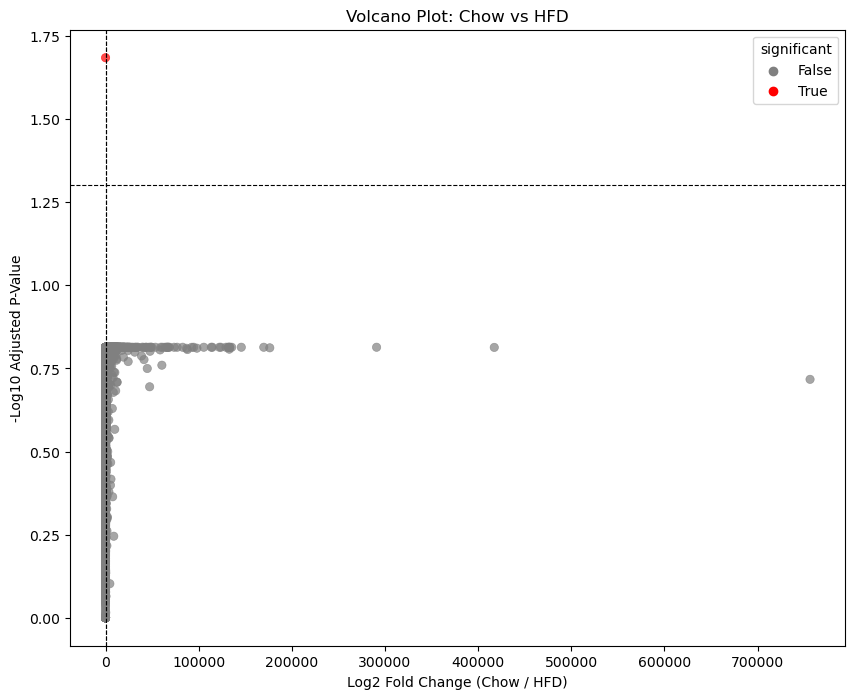

Plotting heatmap...


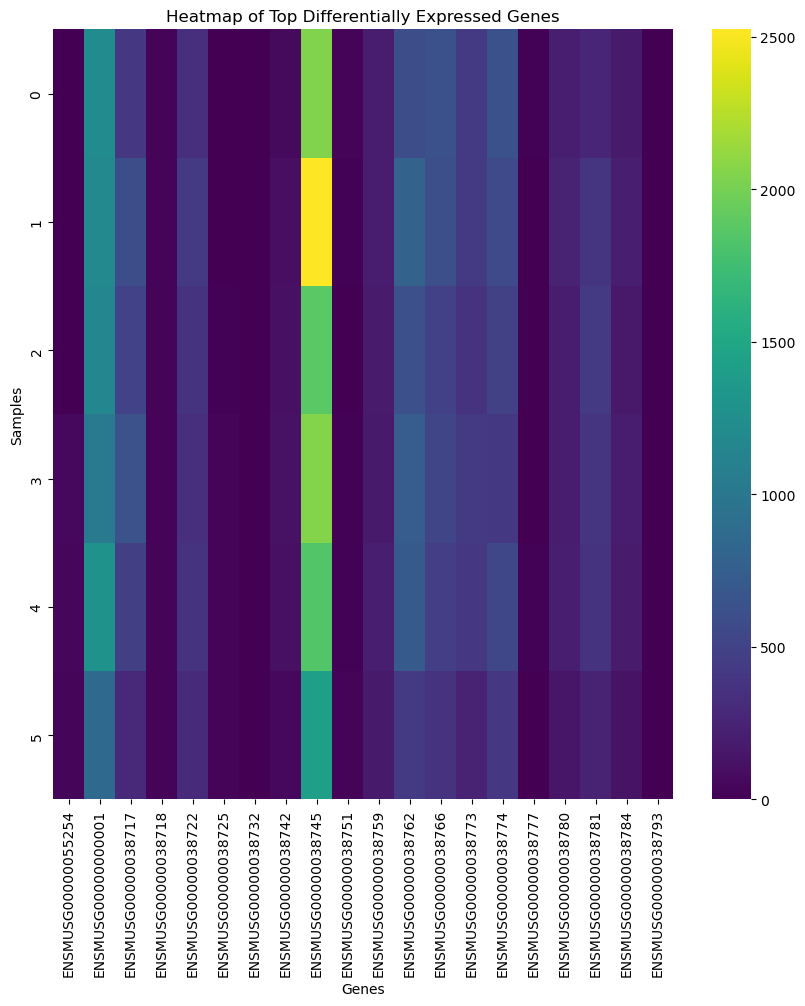

In [65]:
import warnings
# Disable warnings
warnings.filterwarnings("ignore")

# Main test workflow
def test_workflow():
    
    # Initialize IDEADataSet
    dds = IDEADataSet(counts, sample_info)

    # Convert to AnnData
    adata = dds.to_anndata()

    # Perform normalization
    print("Estimating size factors...")
    size_factors(adata)
    print("Normalizing counts...")
    normalize_counts(adata)

    # Estimate dispersions
    print("Estimating dispersions...")
    estimate_dispersions(adata)
    print("Fitting dispersion trend...")
    fit_dispersion_trend(adata)
    print("Shrinking dispersions...")
    shrink_dispersions(adata)

    # Perform differential expression analysis
    contrast = ('condition', 'Chow', 'HFD')
    print("Performing differential expression analysis...")
    results = idea(adata, contrast)

    # Print results
    print("Differential expression analysis results:")
    df_results = results.get_results()
    print(df_results.head())

    print("Plotting Volcano plot...")
    plotVolcano(df_results, contrast[1], contrast[2])

    print("Plotting heatmap...")
    plotHeatmap(df_results, adata)
    
if __name__ == "__main__":
    test_workflow()